## Subscription Retention

### Business Problem

Company XYZ started a subscription model in January, 2015. You get hired as a ﬁrst data scientist at the end of August and, as a ﬁrst task, you are asked to help executives understand how the subscription model is doing.

Therefore, you decide to pull data from all the users who subscribed in January and see, for each month, how many of them unsubscribed. In particular, your boss is interested in:

* A model that predicts monthly retention rate for the diﬀerent subscription price points
* Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?
* How do user country and source aﬀect subscription retention rate? How would you use these ﬁndings to improve the company revenue?

### Roadmap
1. Load the data
2. calculate total number by the end of each billing cycle for each 'monthly-cost'
3. Fit Linear Regression model
4. Predict on billing cycles from 9~12
5. how country affects retention rate?
6. how source affects retention rate?

### Load Data

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [3]:
data = pd.read_csv("subscription.csv", parse_dates = ['subscription_signup_date'])
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,2015-01-01,29,Spain,ads,4,0
1,12474,2015-01-01,49,France,ads,5,0
2,12294,2015-01-01,49,Germany,ads,2,0
3,3878,2015-01-01,49,China,ads,1,0
4,9567,2015-01-01,49,UK,ads,5,0


We have 500,000 users in the dataset and we have 3 different price points namely: 29 dollars, 49 dollars and 99 dollars

In [4]:
data.shape

(500000, 7)

In [5]:
data.subscription_monthly_cost.unique()

array([29, 49, 99])

In [6]:
data.isnull().sum()

user_id                      0
subscription_signup_date     0
subscription_monthly_cost    0
country                      0
source                       0
billing_cycles               0
is_active                    0
dtype: int64

In [7]:
data.describe()

,user_id,subscription_monthly_cost,billing_cycles,is_active
count,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,48.469620,2.384970,0.099998
std,144337.711635,19.570745,2.254952,0.299998
min,1.000000,29.000000,1.000000,0.000000
25%,125000.750000,29.000000,1.000000,0.000000
50%,250000.500000,49.000000,1.000000,0.000000
75%,375000.250000,49.000000,3.000000,0.000000
max,500000.000000,99.000000,8.000000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   user_id                    500000 non-null  int64         
 1   subscription_signup_date   500000 non-null  datetime64[ns]
 2   subscription_monthly_cost  500000 non-null  int64         
 3   country                    500000 non-null  object        
 4   source                     500000 non-null  object        
 5   billing_cycles             500000 non-null  int64         
 6   is_active                  500000 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 26.7+ MB


In [9]:
data.source.unique()

array(['ads', 'seo', 'friend_referral'], dtype=object)

In [10]:
data.is_active.unique()

array([0, 1])

#### Calculate total number by the end of each billing cycle for each 'monthly cost'

In [17]:
res = data.groupby(['subscription_monthly_cost','billing_cycles'])['user_id'].agg(['count'])
pd.DataFrame(res.unstack())

count                                         \
billing_cycles                  1      2      3      4     5     6     7   
subscription_monthly_cost                                                  
29                          57441  21818  12037   7787  5505  4136  3111   
49                         185145  53296  21690  11288  6727  4405  3173   
99                          44788   4724   1471    678   399   226   156   

                                  
billing_cycles                 8  
subscription_monthly_cost         
29                         34527  
49                         14673  
99                           799

#### Calculate retention rate at the end of each billing cycle

In [11]:
def retention_rate(df):
    total_num = len(df)
    rate = []
    for i in [1, 2, 3, 4, 5, 6, 7, 8]:
        rate.append(len(df[df['billing_cycles'] >= i]) / total_num)
        
    return pd.Series(rate, index=[1, 2, 3, 4, 5, 6, 7, 8])

In [12]:
grp = data.groupby('subscription_monthly_cost').apply(retention_rate)


In [13]:
grouped = grp.T

In [14]:
grouped

subscription_monthly_cost,29,49,99
1,1.000000,1.000000,1.000000
2,0.607542,0.383666,0.158769
3,0.458473,0.206247,0.070040
4,0.376232,0.134043,0.042411
5,0.323028,0.096466,0.029676
6,0.285416,0.074072,0.022182
7,0.257157,0.059408,0.017937
8,0.235901,0.048845,0.015007


#### Results
1. For \$29 price point, we have a retention rate of 23\% at the end of 8 billing cycles.
2. Similarly, we have a retention rate of 4.8\% and 1.5\% for price points 59 dollars and 99 dollars resp.

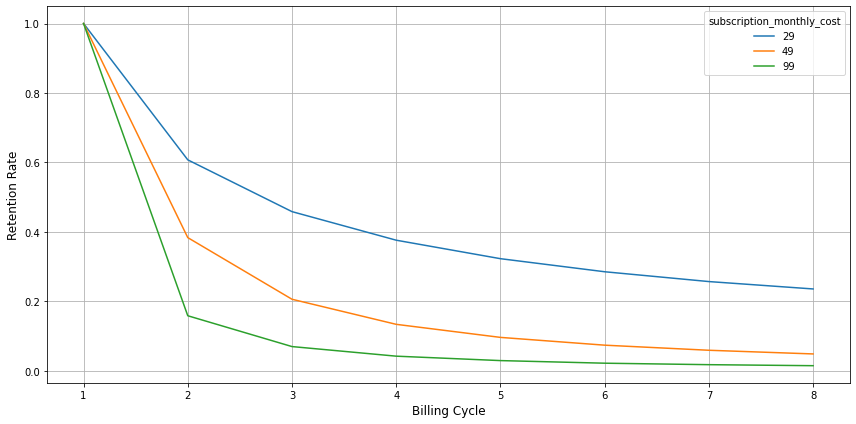

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
grouped.plot(kind = 'line', ax = ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

Retention rate drops a lot after 2nd month.

### Forecasting

We will use ***Linear Regression Model*** to help us forecast the retention rate for the billing cycles 9,10,11 and 12. We already have retention rate at different price points for 8 billing cycles.

#### Feature Engineering for the model

We will include some features to capture non-linearities in the dataset:
1. Billing Cycles 1-8
2. Square of Billing Cycles
3. Log of Billing Cycles

In [17]:
X = np.array([1,2,3,4,5,6,7,8])
x2 = X*X
logx = np.log(X)

In [18]:

rate_29 = grp.loc[29].values
rate_49 = grp.loc[49].values
rate_99 = grp.loc[99].values

features = pd.DataFrame({'x':X,'x2':x2,'logx':logx,'y_29':rate_29,'y_49':rate_49,'y_99':rate_99},
                        columns=['x', 'x2', 'logx', 'y_29', 'y_49', 'y_99'])
features
    

,x,x2,logx,y_29,y_49,y_99
0,1,1,0.000000,1.000000,1.000000,1.000000
1,2,4,0.693147,0.607542,0.383666,0.158769
2,3,9,1.098612,0.458473,0.206247,0.070040
3,4,16,1.386294,0.376232,0.134043,0.042411
4,5,25,1.609438,0.323028,0.096466,0.029676
5,6,36,1.791759,0.285416,0.074072,0.022182
6,7,49,1.945910,0.257157,0.059408,0.017937
7,8,64,2.079442,0.235901,0.048845,0.015007


#### Model Building at 3 different price points

Since, we have only 8 values for the features, we will not split the dataset into test and train.

In [20]:
model_29 = LinearRegression()
model_49 = LinearRegression()
model_99 = LinearRegression()

In [21]:
#Fit linear regression
model_29 = model_29.fit(features[['x','x2','logx']],np.log(features['y_29']))
model_49 = model_49.fit(features[['x','x2','logx']],np.log(features['y_49']))
model_99 = model_99.fit(features[['x','x2','logx']],np.log(features['y_99']))



In [22]:
X = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
x2 = X*X
logx = np.log(X)

#### Model Prediction

In [23]:
#Predict
pred = pd.DataFrame({'x': X, 'x2': x2, 'logx': logx}, columns=['x', 'x2', 'logx'])
pred['pred_29'] = np.exp(model_29.predict(pred[['x','x2','logx']]))
pred['pred_49'] = np.exp(model_49.predict(pred[['x','x2','logx']]))
pred['pred_99'] = np.exp(model_99.predict(pred[['x','x2','logx']]))
pred

,x,x2,logx,pred_29,pred_49,pred_99
0,1,1,0.000000,0.999502,1.003844,0.992027
1,2,4,0.693147,0.608619,0.378064,0.163419
2,3,9,1.098612,0.458101,0.208259,0.069098
3,4,16,1.386294,0.375765,0.135129,0.041513
4,5,25,1.609438,0.322898,0.096500,0.029441
5,6,36,1.791759,0.285608,0.073590,0.022695
6,7,49,1.945910,0.257606,0.058968,0.018197
7,8,64,2.079442,0.235610,0.049174,0.014781
8,9,81,2.197225,0.217726,0.042412,0.011960
9,10,100,2.302585,0.202786,0.037674,0.009529


A graph of true and predicted values suggest that our model is performing really well. The true and predicted values nearly overlaps.

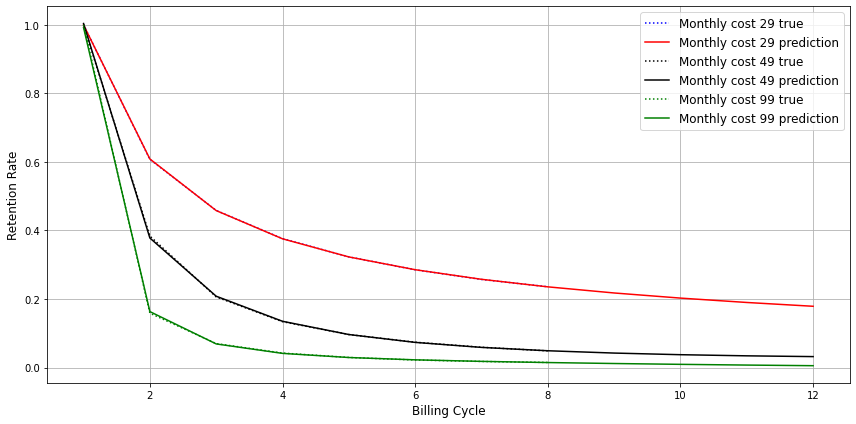

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(features['x'], features['y_29'], 'b:', label='Monthly cost 29 true')
ax.plot(pred['x'], pred['pred_29'], 'r-', label='Monthly cost 29 prediction')
ax.plot(features['x'], features['y_49'], 'k:', label='Monthly cost 49 true')
ax.plot(pred['x'], pred['pred_49'], 'k-', label='Monthly cost 49 prediction')
ax.plot(features['x'], features['y_99'], 'g:', label='Monthly cost 99 true')
ax.plot(pred['x'], pred['pred_99'], 'g-', label='Monthly cost 99 prediction')
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()


#### Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

17\% are subscribed at the end of 12 months for 29 dollars subscription plan. 3.2\% are subscribed at 49 dollars and .05\% are subscribed at 99 dollars.

In [78]:
pred.iloc[[11],[3,4,5]]

,pred_29,pred_49,pred_99
11,0.178925,0.032107,0.005599


### Retention rate by country
How do user country and source aﬀect subscription retention rate? How would you use these ﬁndings to improve the company revenue?

In [25]:
grouped_country= data.groupby(['country']).apply(retention_rate)
grouped_country

,1,2,3,4,5,6,7,8
country,,,,,,,,
China,1.0,0.514831,0.402777,0.360426,0.336274,0.319856,0.307084,0.295453
France,1.0,0.334946,0.177732,0.119004,0.088479,0.069935,0.058341,0.049688
Germany,1.0,0.451284,0.278411,0.195910,0.146474,0.115151,0.093868,0.078465
India,1.0,0.446728,0.326962,0.284527,0.261603,0.246736,0.234847,0.225769
Italy,1.0,0.341684,0.179502,0.119914,0.090015,0.071135,0.057523,0.048695
Spain,1.0,0.339098,0.178985,0.119879,0.088648,0.070065,0.057617,0.048503
UK,1.0,0.458938,0.285133,0.198067,0.149421,0.117356,0.095735,0.079494
US,1.0,0.456509,0.284255,0.198853,0.149284,0.117398,0.094875,0.078981


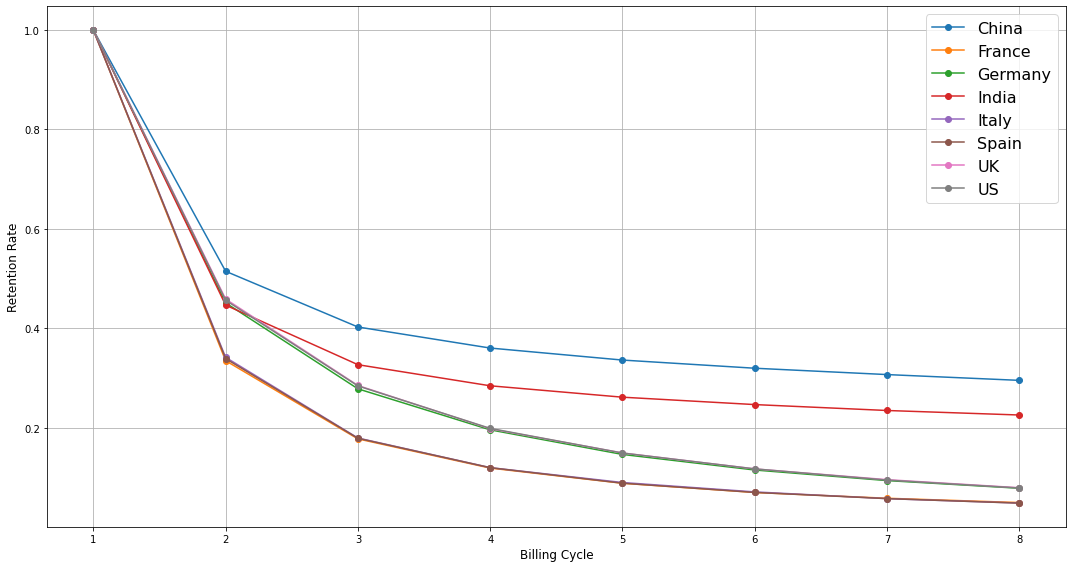

In [26]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
grouped_country.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [91]:
grouped_country.T.iloc[-1:]

country,China,France,Germany,India,Italy,Spain,UK,US
8,0.295453,0.049688,0.078465,0.225769,0.048695,0.048503,0.079494,0.078981


#### Results

1. Customers from India and China have the slowest churn rate. So, we should target them in a way that we can retain them for longer

2. UK, US, Germany have medium 'retention rate'.

3. France, Italy, Spain has the lowest 'retention rate'


### Influence of Source

In [31]:
grouped_source= data.groupby(['source']).apply(retention_rate)
grouped_source

,1,2,3,4,5,6,7,8
source,,,,,,,,
ads,1.0,0.388873,0.222094,0.152607,0.114959,0.092043,0.076756,0.066237
friend_referral,1.0,0.699443,0.617038,0.561282,0.519854,0.487596,0.461110,0.436507
seo,1.0,0.562395,0.420012,0.337594,0.286254,0.247877,0.218680,0.194475


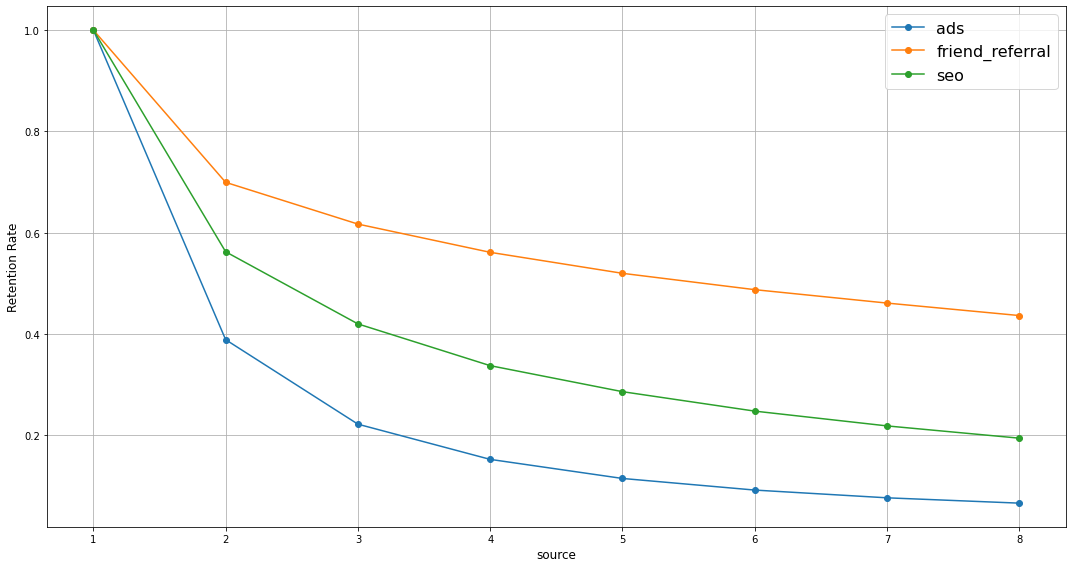

In [28]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
grouped_source.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('source', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

#### Results

1. We can see that subscribers from 'friend_referral' are most loyal and have the highest retentiona rate at the end of the billing cycle.

2. Ads are not doing very well. Maybe, customize the ads according to the user's interests

3. To improve the revenue,launch some program to improve 'user referral'. For example, current subscribers can invite new users to subscribe. If your friends subscribe, you get rewarded with a certain amount of money or credit. This could lead to more subscribers.